In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [2]:
def rel_l2(predictions, targets):
    """Relative L2 metric.

    Args:
        predictions (np.ndarray): prediction array
        targets (np.ndarray): target array

    Returns:
        float: relative L2 error
    """
    return np.linalg.norm(predictions - targets) / np.linalg.norm(targets)


In [3]:
def get_TChem_solution(tchem_file):
  data = np.genfromtxt(tchem_file, dtype=str)
  Header = (data[0,:]).tolist()
  solTchem = (data[1:,:]).astype(float)
  niterT, Nvars = np.shape(solTchem)
  Nsamples = len(np.where(solTchem[:,0]==-1)[0])
  print('Number of Samples',Nsamples)
  print(niterT, Nvars)
  return Header, solTchem.reshape( int(niterT/Nsamples), Nsamples,Nvars)

In [4]:
def plot_tchem_vs_e3sm(ax=None, tchem_values=None,e3sm_values=None, var_label=None,legend_name=None):
    min_value = tchem_values.min()
    max_value = tchem_values.max()
    ax.plot(tchem_values, e3sm_values,'o',label=legend_name)
    ax.plot([min_value,max_value],[min_value,max_value],'k--')
    ax.set_xlabel('TChem')
    ax.set_ylabel('E3SM')
    ax.set_title(var_label)
    ax.legend()


In [5]:
root_path="/Users/odiazib/Documents/CODE/gitlab-ex/tchem_atm/verification/e3sm_verification/outputs"
tchem_solver_type="impEuler"
# tchem_solver_type="cvode"
# tchem_solver_type="trbdf2"

In [6]:
locas = ["BRW","LA"]
paths_files={}
paths_files.update({"tchem":{}})
paths_files.update({"tchem_strato":{}})
paths_files.update({"standalone_impl":{}})
paths_files.update({"standalone":{}})
# print("before")
for iloc in locas:
  paths_files["tchem"].update({iloc:{}})
  paths_files["tchem_strato"].update({iloc:{}})
  paths_files["tchem"][iloc].update({"euler":root_path+"/tchem/"+iloc+"/"+tchem_solver_type+"/full_gas.dat"})
  # paths_files["tchem"][iloc].update({"euler":root_path+"/tchem/"+iloc+"/"+tchem_solver_type+"/full_gas_cvode.dat"})
  # paths_files["tchem"][iloc].update({"euler":root_path+"/tchem/"+iloc+"/"+tchem_solver_type+"/full_gas_trbdf.dat"})
  paths_files["tchem"][iloc].update({"net_prod_rates":root_path+"/tchem/"+iloc+"/netProductionRates/net_production_rates.dat"})
  paths_files["tchem"][iloc].update({"rate_of_progress":root_path+"/tchem/"+iloc+"/rateofProgress/rate_of_progress.dat"})
  paths_files["tchem_strato"][iloc].update({"euler":root_path+"/tchem/"+iloc+"/stratoSolver/full_gas_stratosphere.dat"})
  paths_files["tchem_strato"][iloc].update({"net_prod_rates":root_path+"/tchem/"+iloc+"/stratoNetProductionRates//net_production_rates_stratosphere.dat"})
  paths_files["standalone_impl"].update({iloc:{}})
  paths_files["standalone"].update({iloc:{}})
  paths_files["standalone"][iloc].update({"module_path":root_path+"/standalone/"+iloc+"/mam_stand_uci_output.py"})
  paths_files["standalone"][iloc].update({"module_name":"mam_stand_uci_output"})
  paths_files["standalone_impl"][iloc].update({"module_path":root_path+"/standalone_full_implicit/"+iloc+"/mam_stand_uci_output.py"})
  paths_files["standalone_impl"][iloc].update({"module_name":"mam_stand_uci_output"})

In [7]:
# paths_files["standalone"]["LA"]

In [8]:
standalone_impl={}
for iloc in locas:
  spec = importlib.util.spec_from_file_location(
    "mam_stand_uci_output", paths_files["standalone_impl"][iloc]["module_path"])
  data_e3sm = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(data_e3sm)
  standalone_impl.update({iloc:data_e3sm})

In [9]:
standalone={}
for iloc in locas:
  spec = importlib.util.spec_from_file_location(
    "mam_stand_uci_output", paths_files["standalone"][iloc]["module_path"])
  data_e3sm = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(data_e3sm)
  standalone.update({iloc:data_e3sm})

In [10]:
react_pairs = zip([40,41],[104,105])

tchem_data={}

for iloc in locas:
  tchem_data.update({iloc:{}})
  tchem_file = paths_files["tchem"][iloc]['euler']
  Header_troposphere, solTchem = get_TChem_solution(tchem_file)
  tchem_data[iloc].update({'vmr':solTchem})
  reaction_tchem_net_production_rates = np.loadtxt(paths_files["tchem"][iloc]["net_prod_rates"])
  tchem_data[iloc].update({'net_prod_rates':reaction_tchem_net_production_rates})
  nt, nsamples, nvars_t = solTchem.shape
  tchem_rate_of_progress = np.loadtxt(paths_files["tchem"][iloc]["rate_of_progress"])
  for r1,r2 in zip([40,41],[104,105]):
     tchem_rate_of_progress[:,r1] += tchem_rate_of_progress[:,r2]
  tchem_data[iloc].update({'rate_of_progress':tchem_rate_of_progress})



tchem_data_strato={}
for iloc in locas:
  tchem_data_strato.update({iloc:{}})
  tchem_file = paths_files["tchem_strato"][iloc]['euler']
  Header_strato, solTchem = get_TChem_solution(tchem_file)
  tchem_data_strato[iloc].update({'vmr':solTchem})
  reaction_tchem_net_production_rate_stratosphere = np.loadtxt(paths_files["tchem_strato"][iloc]["net_prod_rates"])
  tchem_data_strato[iloc].update({'net_prod_rates':reaction_tchem_net_production_rate_stratosphere})

Number of Samples 579
1158 88
Number of Samples 592
1184 88
Number of Samples 621
1242 13
Number of Samples 608
1216 13


In [11]:
# It depends of chem.data
explicit_species_idx = [15,  16,  17,  20,  31,  32,  33,  34,  35,  36,
                            37,  38,  47,  48,  49,  50,  51,  52,  53,  57,
                            58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
                            68,  69,  70,  71,  72,  73 ]


In [12]:
soport_files_dir=""


In [13]:
# get species name in e3sm and order:
import numpy as np
try:
    import ruamel_yaml as yaml
except ImportError:
    from ruamel import yaml
from email.utils import formatdate
BlockMap = yaml.comments.CommentedMap
file_name =soport_files_dir+"uci_wnames.yaml"


In [14]:
with open(file_name, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
inputs = data_loaded['input']['fixed']
var_names_e3sm = inputs['solsym']


In [15]:
def get_values_e3sm_vmr(data_e3sm):
    y_start_1d = np.array(data_e3sm.output.base_sol_init[0])
    y_end_1d = np.array(data_e3sm.output.base_sol[0])
    pver = data_e3sm.input.pver[0][0]
    vmr_shape = data_e3sm.input.shape_of_vmr[0]
    ncol=vmr_shape[0]
    pver=vmr_shape[1]
    nvars=vmr_shape[2]
    ltrop_sol= data_e3sm.input.ltrop_sol[0]
    y_start = y_start_1d.reshape(ncol,pver,nvars, order='F')
    y_end = y_end_1d.reshape(ncol,pver,nvars, order='F')
    y_start_test = y_start[0,ltrop_sol[0]:,:]
    y_end_test = y_end[0,ltrop_sol[0]:,:]
    for icol in range(1,ncol):
      y_start_test = np.vstack((y_start_test,y_start[icol,ltrop_sol[icol]:,:]))
      y_end_test = np.vstack((y_end_test,y_end[icol,ltrop_sol[icol]:,:]))
    return y_end_test


def get_values_e3sm_net_production_rates(data_e3sm):
    pver = data_e3sm.input.pver[0][0]
    ltrop_sol= data_e3sm.input.ltrop_sol[0]
    vmr_shape = data_e3sm.input.shape_of_vmr[0]
    reaction_net_production_rate_uci_1d = np.array(data_e3sm.output.net_production_rates[0])
    ncol=vmr_shape[0]
    pver=vmr_shape[1]
    # nvars=vmr_shape[2]
    n_net_pro = int(len(reaction_net_production_rate_uci_1d)/pver/ncol)
    reaction_net_production_rate_uci_3d = reaction_net_production_rate_uci_1d.reshape(ncol,pver,n_net_pro, order='F')
    reaction_net_production_rate_uci_test = reaction_net_production_rate_uci_3d[0,ltrop_sol[0]:,:]
    for icol in range(1,ncol):
      reaction_net_production_rate_uci_test = \
      np.vstack((reaction_net_production_rate_uci_test,reaction_net_production_rate_uci_3d[icol,ltrop_sol[icol]:,:]))

    return reaction_net_production_rate_uci_test

def get_values_e3sm_rate_of_progress(data_e3sm):
    vmr_shape = data_e3sm.input.shape_of_vmr[0]
    pver = data_e3sm.input.pver[0][0]
    ltrop_sol= data_e3sm.input.ltrop_sol[0]
    ltrop_sol= data_e3sm.input.ltrop_sol[0]
    ncol=vmr_shape[0]
    pver=vmr_shape[1]
    rate_of_progress_uci_1d = np.array(data_e3sm.output.rate_of_progress[0])
    n_reactions = int(len(rate_of_progress_uci_1d)/pver/ncol)
    rate_of_progress_uci_3d=rate_of_progress_uci_1d.reshape(ncol,pver,n_reactions, order='F')
    rate_of_progress_uci_test = rate_of_progress_uci_3d[0,ltrop_sol[0]:,:]
    for icol in range(1,ncol):
      rate_of_progress_uci_test = \
      np.vstack((rate_of_progress_uci_test,rate_of_progress_uci_3d[icol,ltrop_sol[icol]:,:]))
    return  rate_of_progress_uci_test

def get_stratosphere_vmr(data_e3sm):
    y_start_1d = np.array(data_e3sm.output.base_sol_init[0])
    y_end_1d = np.array(data_e3sm.output.base_sol[0])
    pver = data_e3sm.input.pver[0][0]
    vmr_shape = data_e3sm.input.shape_of_vmr[0]
    ncol=vmr_shape[0]
    pver=vmr_shape[1]
    nvars=vmr_shape[2]
    ltrop_sol= data_e3sm.input.ltrop_sol[0]
    y_start = y_start_1d.reshape(ncol,pver,nvars, order='F')
    y_end = y_end_1d.reshape(ncol,pver,nvars, order='F')
    y_start_stra = y_start[0,:ltrop_sol[0],:]
    y_end_stra = y_end[0,:ltrop_sol[0],:]
    for icol in range(1,ncol):
      y_start_stra = np.vstack((y_start_stra,y_start[icol,:ltrop_sol[icol],:]))
      y_end_stra = np.vstack((y_end_stra,y_end[icol,:ltrop_sol[icol],:]))
    return y_start_stra, y_end_stra


def get_values_e3sm_stratosphere_net_production_rates(data_e3sm):
    pver = data_e3sm.input.pver[0][0]
    ltrop_sol= data_e3sm.input.ltrop_sol[0]
    vmr_shape = data_e3sm.input.shape_of_vmr[0]
    reaction_net_production_rate_uci_1d = np.array(data_e3sm.output.net_production_rates[0])
    ncol=vmr_shape[0]
    pver=vmr_shape[1]
    # nvars=vmr_shape[2]
    n_net_pro = int(len(reaction_net_production_rate_uci_1d)/pver/ncol)
    reaction_net_production_rate_uci_3d = reaction_net_production_rate_uci_1d.reshape(ncol,pver,n_net_pro, order='F')
    reaction_net_production_rate_uci_stra= reaction_net_production_rate_uci_3d[0,:ltrop_sol[0],:]
    for icol in range(1,ncol):
     reaction_net_production_rate_uci_stra = \
      np.vstack((reaction_net_production_rate_uci_stra,\
                 reaction_net_production_rate_uci_3d[icol,:ltrop_sol[icol],:]))
    return reaction_net_production_rate_uci_stra

In [16]:
ny = 5
nx = int(len(var_names_e3sm)/ny) +1
names_tchem=Header_troposphere[6:]
label_format ="{var_name:s} ({error:.2e})"

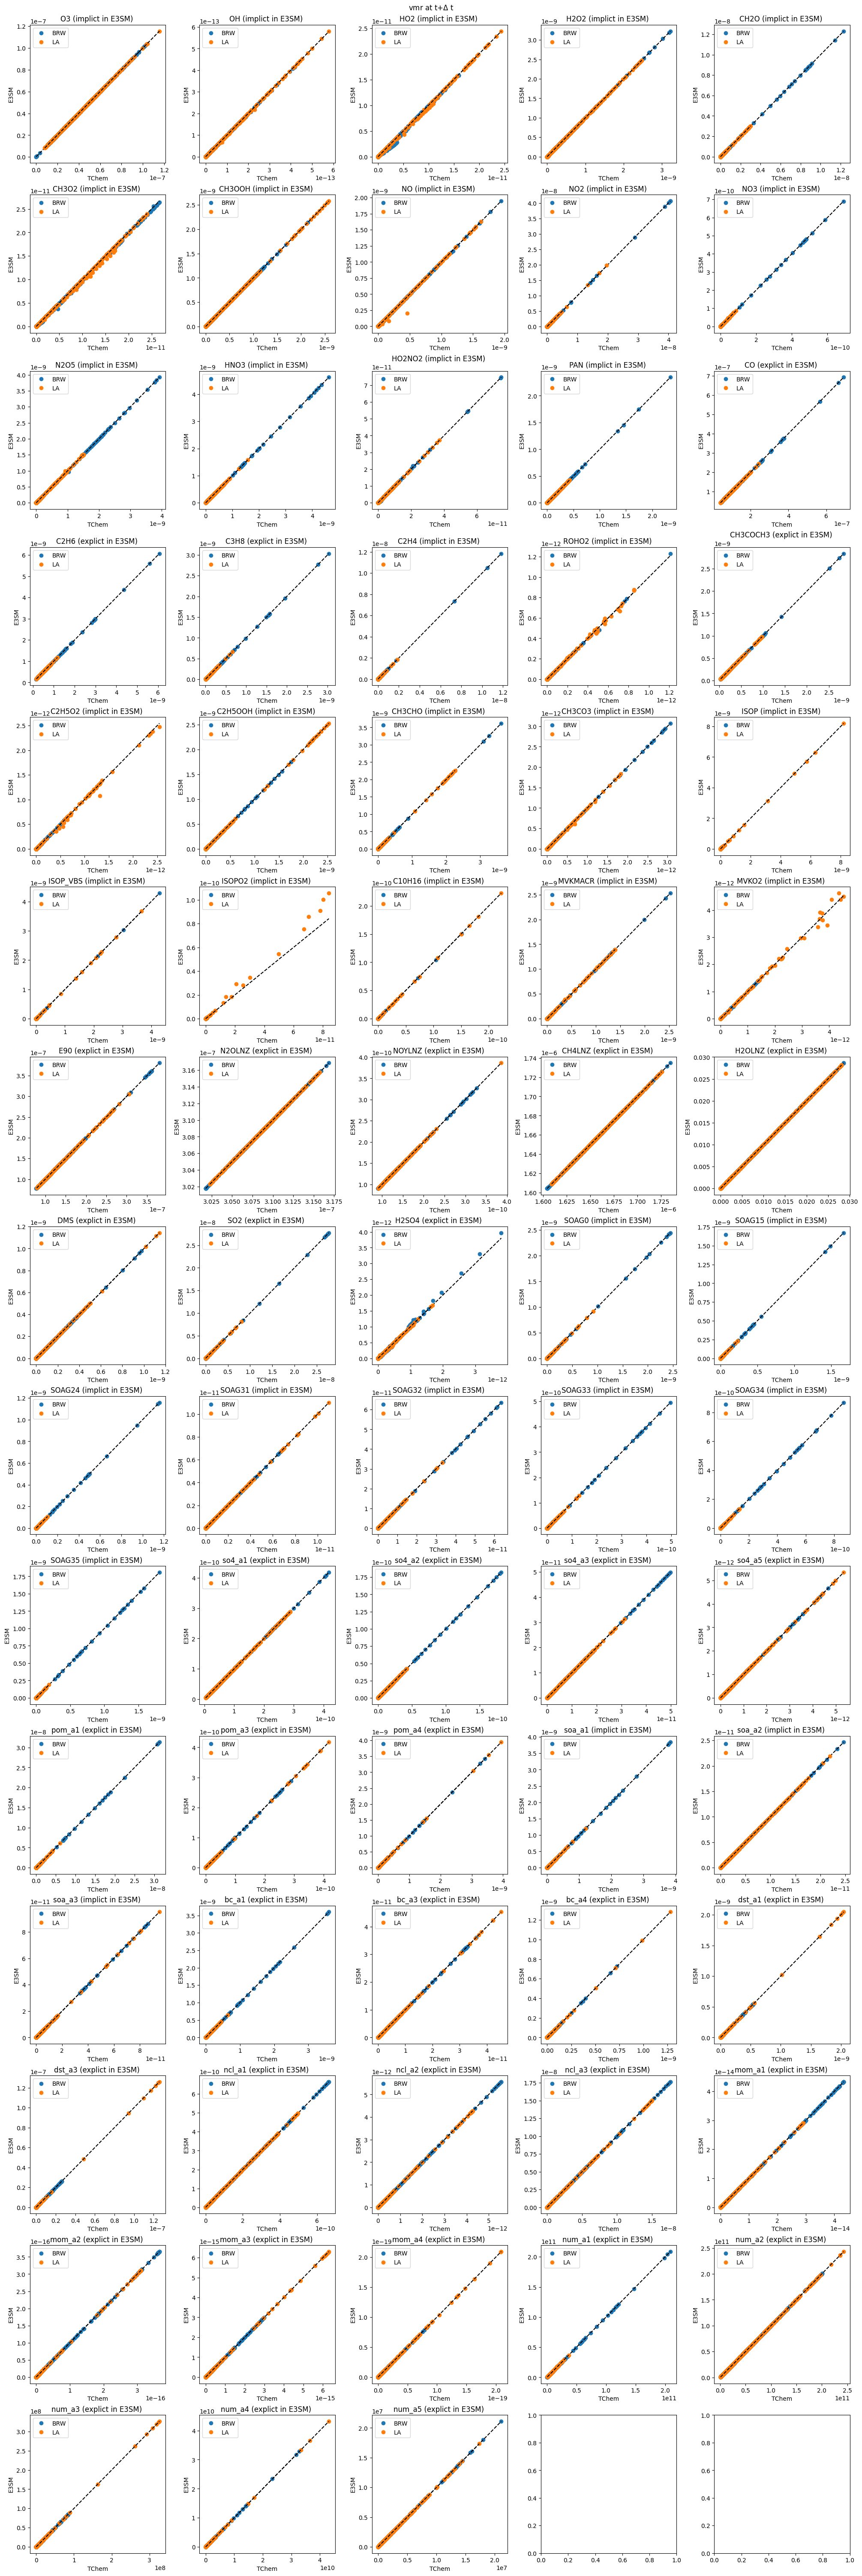

In [17]:
fig, axs = plt.subplots(nx, ny, layout="constrained", figsize=[ny*4,nx*4])
fig.suptitle('vmr at t+$\Delta$ t')

RRMSE_time_int={}
for iloc in locas:
  RRMSE_time_int.update({iloc:{"RRMSE":[]}})

for i,var in enumerate(var_names_e3sm):
    j = int(i/ny)%nx
    k = i%ny
    idx_tchem =  Header_troposphere.index(var)
    if i+1 in explicit_species_idx:
      var_name = var + ' (explict in E3SM) '
    else:
      var_name = var + ' (implict in E3SM) '
    for iloc in locas:
      y_end_test = get_values_e3sm_vmr(standalone[iloc])
      solTchem = tchem_data[iloc]["vmr"]
      tchem_values = solTchem[-1,:,idx_tchem]
      e3sm_values = y_end_test[:,i]
      RRMSE = rel_l2(tchem_values, e3sm_values)
      RRMSE_time_int[iloc]["RRMSE"] +=[RRMSE]
      var_label =var_name
      plot_tchem_vs_e3sm(ax = axs[j][k], tchem_values=tchem_values,
                      e3sm_values=e3sm_values, var_label=var_label,legend_name=iloc)

plt.savefig("time_integration_all_species_"+tchem_solver_type+".pdf")

In [18]:
idx_error_time_int = np.array(RRMSE_time_int).argsort()

/var/folders/6k/g7sr4c6n26ddzjy8k30nrnb4002p1l/T/ipykernel_18668/1886437541.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return np.linalg.norm(predictions - targets) / np.linalg.norm(targets)


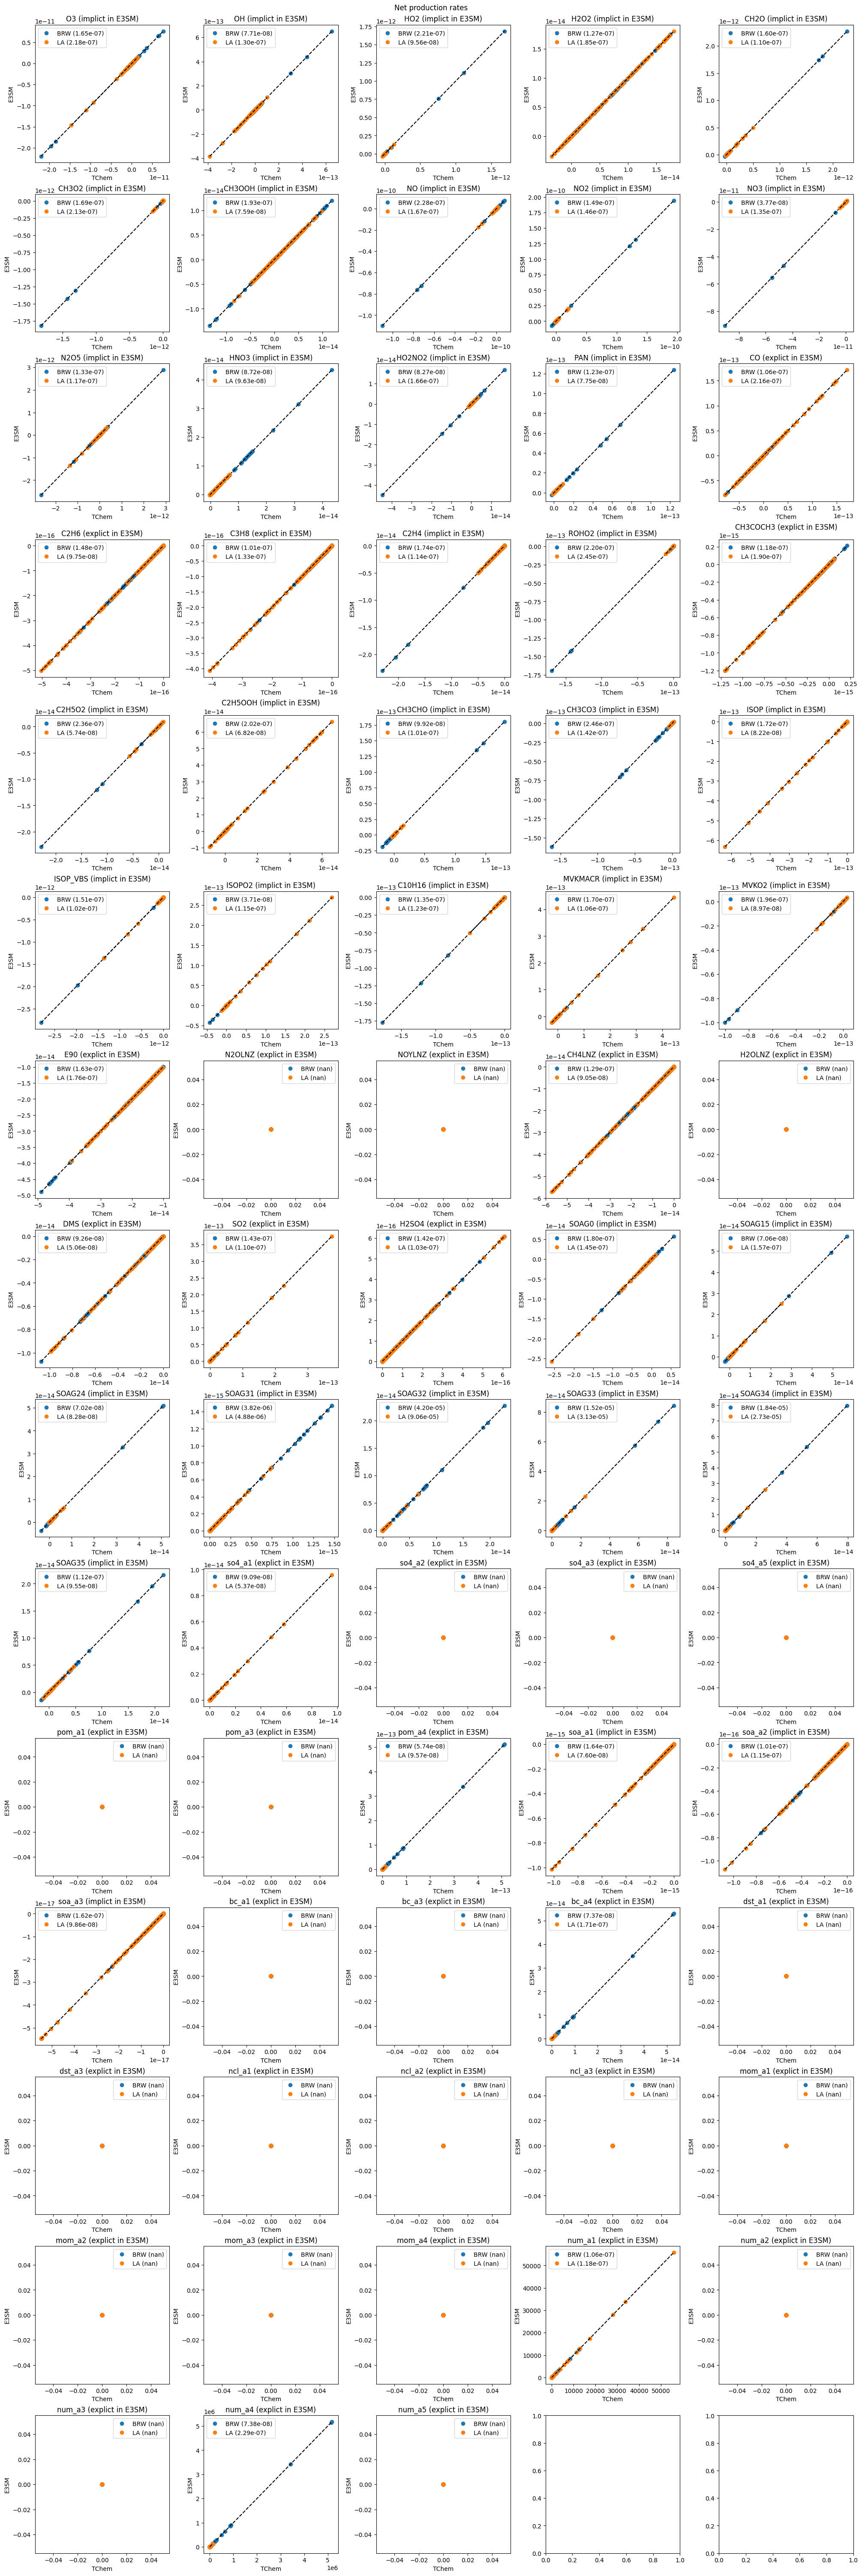

In [19]:
ny = 5
nx = int(len(var_names_e3sm)/ny) +1
fig, axs = plt.subplots(nx, ny, layout="constrained", figsize=[ny*4,nx*4])
fig.suptitle('Net production rates')

RRMSE_net_p_rate={}
for iloc in locas:
  RRMSE_net_p_rate.update({iloc:{"RRMSE":[]}})

for i,var in enumerate(var_names_e3sm):
    j = int(i/ny)%nx
    k = i%ny
    idx_tchem =  names_tchem.index(var)

    for iloc in locas:
      reaction_tchem_net_production_rates = tchem_data[iloc]["net_prod_rates"]
      tchem_values= reaction_tchem_net_production_rates[:,idx_tchem]
      reaction_net_production_rate_uci_test = get_values_e3sm_net_production_rates(standalone_impl[iloc])
      e3sm_values =reaction_net_production_rate_uci_test[:,i]
      RRMSE=rel_l2(tchem_values, e3sm_values)
      RRMSE_net_p_rate[iloc]["RRMSE"]+= [RRMSE]

      if i+1 in explicit_species_idx:
        var_name = var + ' (explict in E3SM)'
      else:
        var_name = var + ' (implict in E3SM)'

      var_label = label_format.format(var_name=iloc,error=RRMSE)

      plot_tchem_vs_e3sm(ax = axs[j][k], tchem_values=tchem_values,
                      e3sm_values=e3sm_values, var_label=var_name, legend_name=var_label)

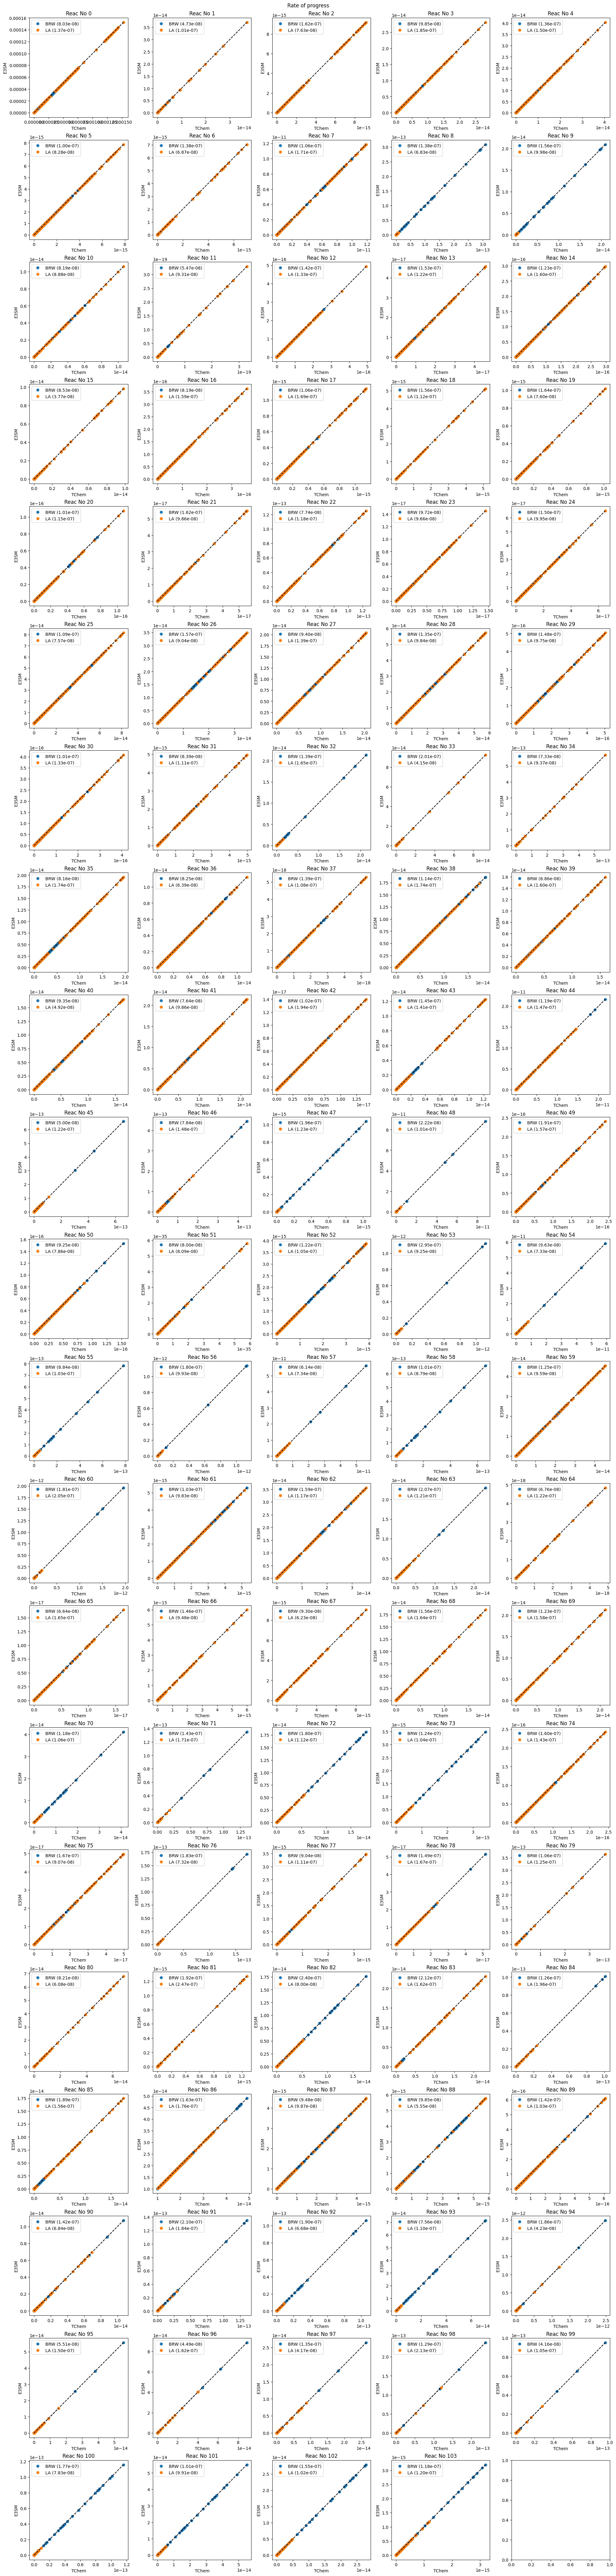

In [20]:
ny = 5
n_reactions=104
nx = int(n_reactions/ny) +1


RRMSE_reaction_rate={}
for iloc in locas:
  RRMSE_reaction_rate.update({iloc:{"RRMSE":[]}})

fig, axs = plt.subplots(nx, ny, layout="constrained", figsize=[ny*4,nx*4])
fig.suptitle('Rate of progress')
for i in range(n_reactions):
    j = int(i/ny)%nx
    k = i%ny
    for iloc in locas:
      tchem_rate_of_progress = tchem_data[iloc]["rate_of_progress"]
      tchem_values= tchem_rate_of_progress[:,i]
      rate_of_progress_uci_test = get_values_e3sm_rate_of_progress(standalone_impl[iloc])
      e3sm_values=rate_of_progress_uci_test[:,i]
      RRMSE= rel_l2(tchem_values, e3sm_values)
      RRMSE_reaction_rate[iloc]["RRMSE"]+= [RRMSE]
      var_label = label_format.format(var_name=iloc,error=RRMSE)
      plot_tchem_vs_e3sm(ax = axs[j][k], tchem_values=tchem_values,
                      e3sm_values=e3sm_values, var_label='Reac No '+str(i), legend_name=var_label)

In [21]:
no_plot_worst_rrmse=12
nx=3
ny=4
idx_error_rate_progress = np.array(RRMSE_reaction_rate["LA"]["RRMSE"]).argsort()
plot_these_reactions = idx_error_rate_progress[-no_plot_worst_rrmse:]

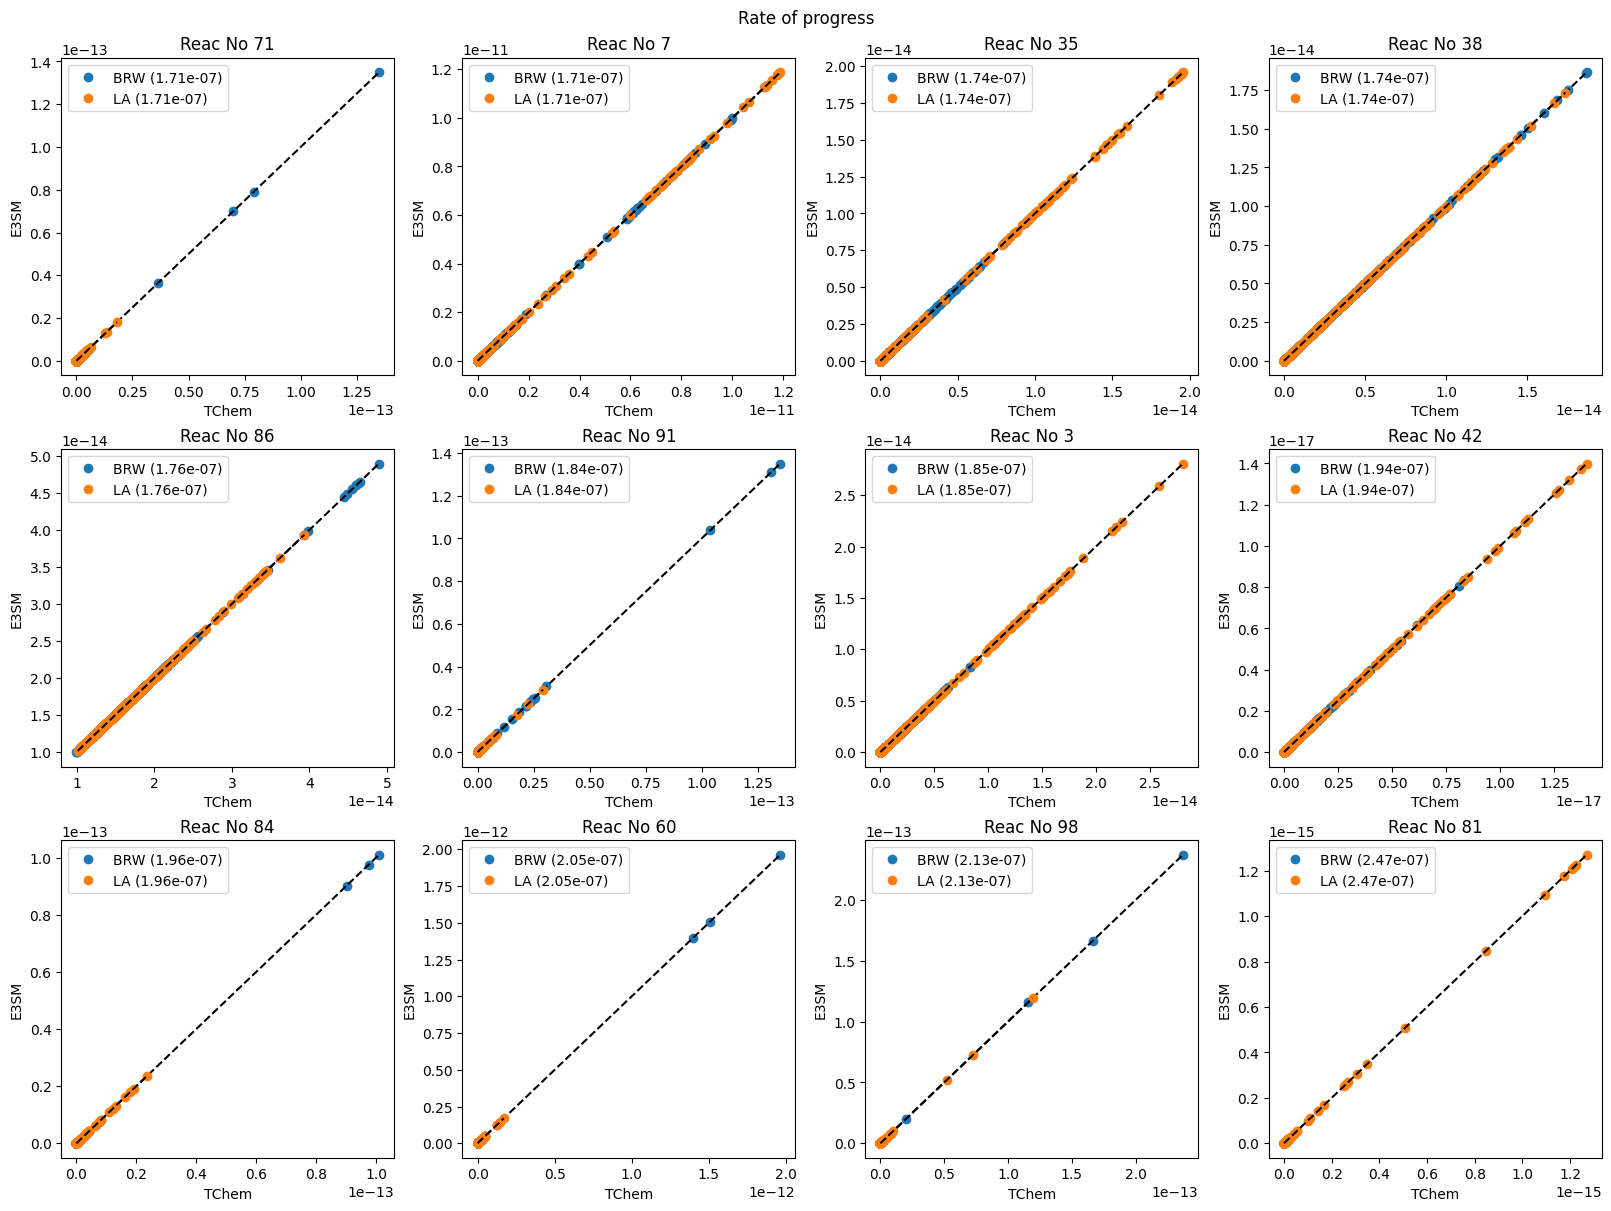

In [22]:
fig, axs = plt.subplots(nx, ny, layout="constrained", figsize=[ny*4,nx*4])
fig.suptitle('Rate of progress')
for i,ireac in enumerate(plot_these_reactions):
    j = int(i/ny)%nx
    k = i%ny
    for iloc in locas:
      tchem_rate_of_progress = tchem_data[iloc]["rate_of_progress"]
      tchem_values= tchem_rate_of_progress[:,ireac]
      rate_of_progress_uci_test = get_values_e3sm_rate_of_progress(standalone_impl[iloc])
      e3sm_values=rate_of_progress_uci_test[:,ireac]

      var_label = label_format.format(var_name=iloc,error=RRMSE_reaction_rate["LA"]["RRMSE"][ireac])
      plot_tchem_vs_e3sm(ax = axs[j][k], tchem_values=tchem_values,
                      e3sm_values=e3sm_values, var_label='Reac No '+str(ireac),legend_name=var_label)
plt.savefig("rate_of_progress_worst.pdf")

In [23]:
idx_error_RRMSE_time_int = np.array(RRMSE_time_int["LA"]["RRMSE"]).argsort()
plot_these_variables = idx_error_RRMSE_time_int[-no_plot_worst_rrmse:]

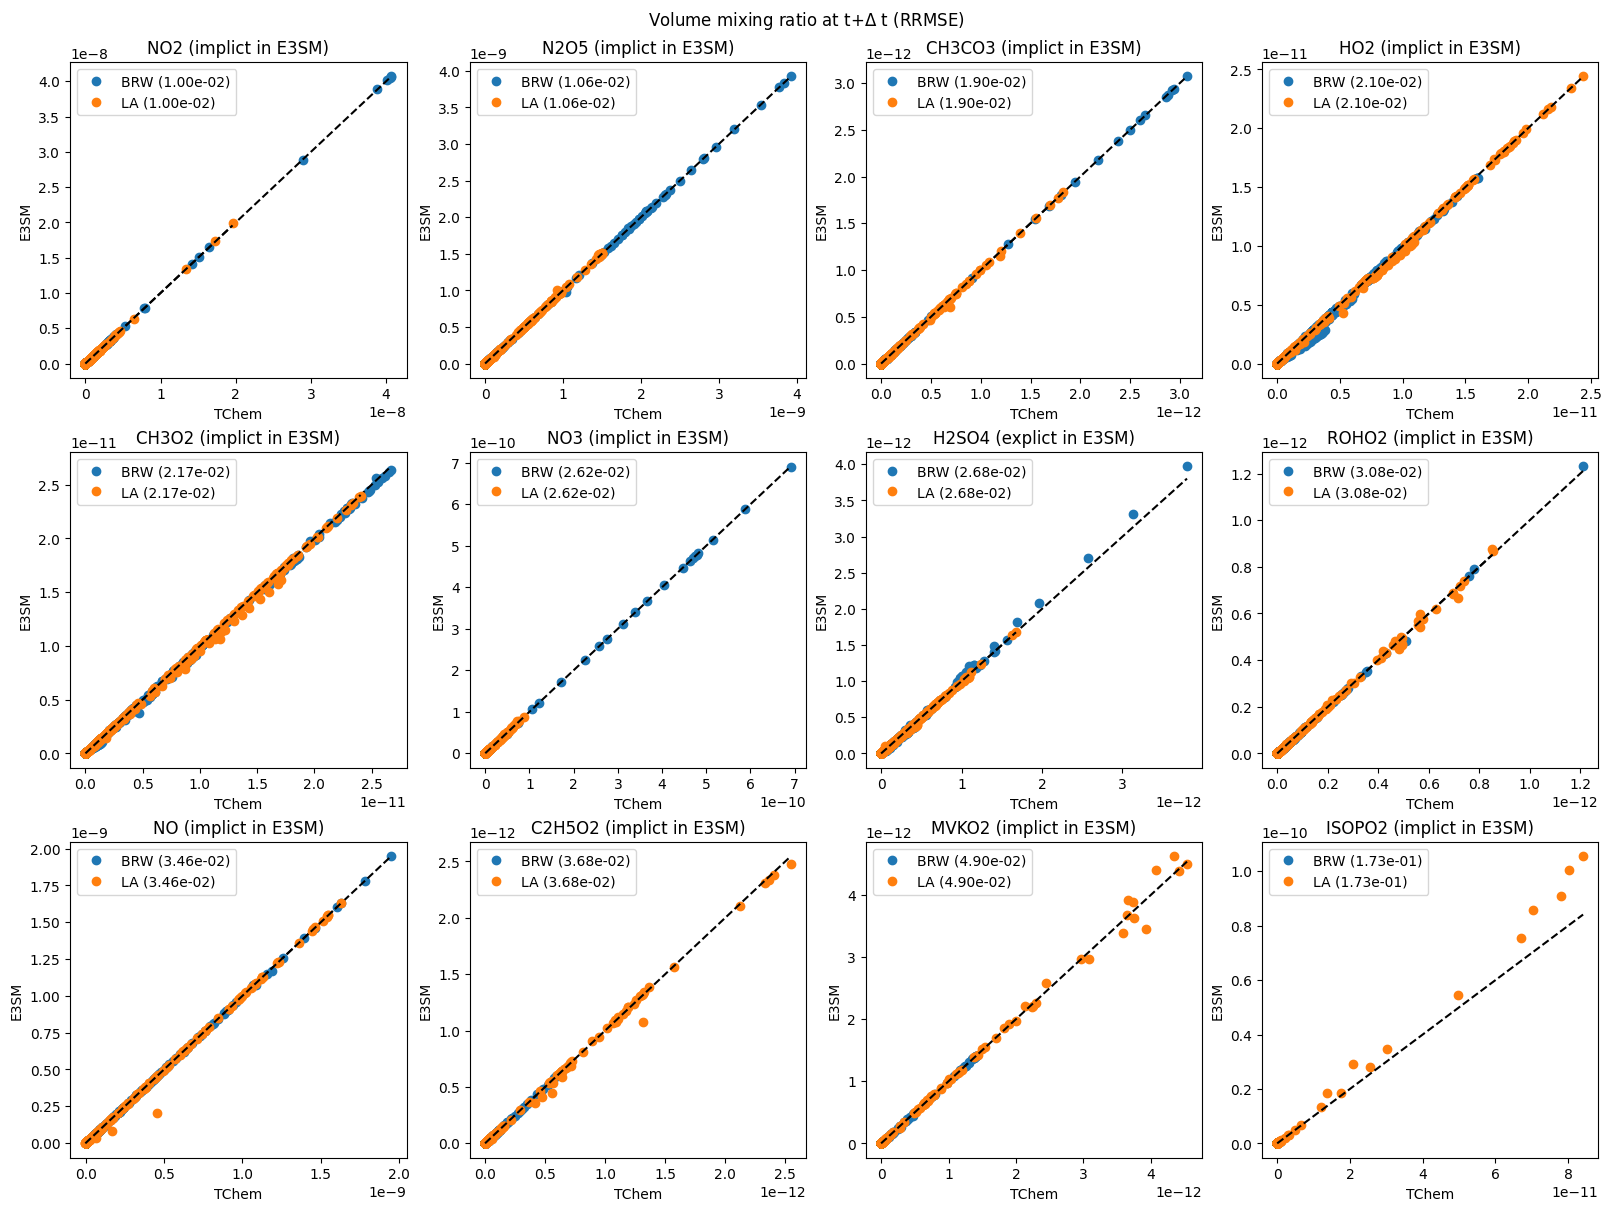

In [24]:
fig, axs = plt.subplots(nx, ny, layout="constrained", figsize=[ny*4,nx*4])
fig.suptitle('Volume mixing ratio at t+$\Delta$ t (RRMSE)')

for i,var_idx in enumerate(plot_these_variables):
    var = var_names_e3sm[var_idx]
    j = int(i/ny)%nx
    k = i%ny
    idx_tchem =  Header_troposphere.index(var)
    idx_e3sm = var_idx
    if var_idx+1 in explicit_species_idx:
      var_name = var + ' (explict in E3SM)'
    else:
      var_name = var + ' (implict in E3SM)'

    for iloc in locas:
      y_end_test = get_values_e3sm_vmr(standalone[iloc])
      solTchem = tchem_data[iloc]["vmr"]
      tchem_values = solTchem[-1,:,idx_tchem]
      e3sm_values = y_end_test[:,idx_e3sm]
      var_label = label_format.format(var_name=iloc,error=RRMSE_time_int["LA"]["RRMSE"][idx_e3sm])
      plot_tchem_vs_e3sm(ax = axs[j][k], tchem_values=tchem_values,
                      e3sm_values=e3sm_values, var_label=var_name,legend_name=var_label)
plt.savefig("time_integration_worst_"+tchem_solver_type+".pdf")

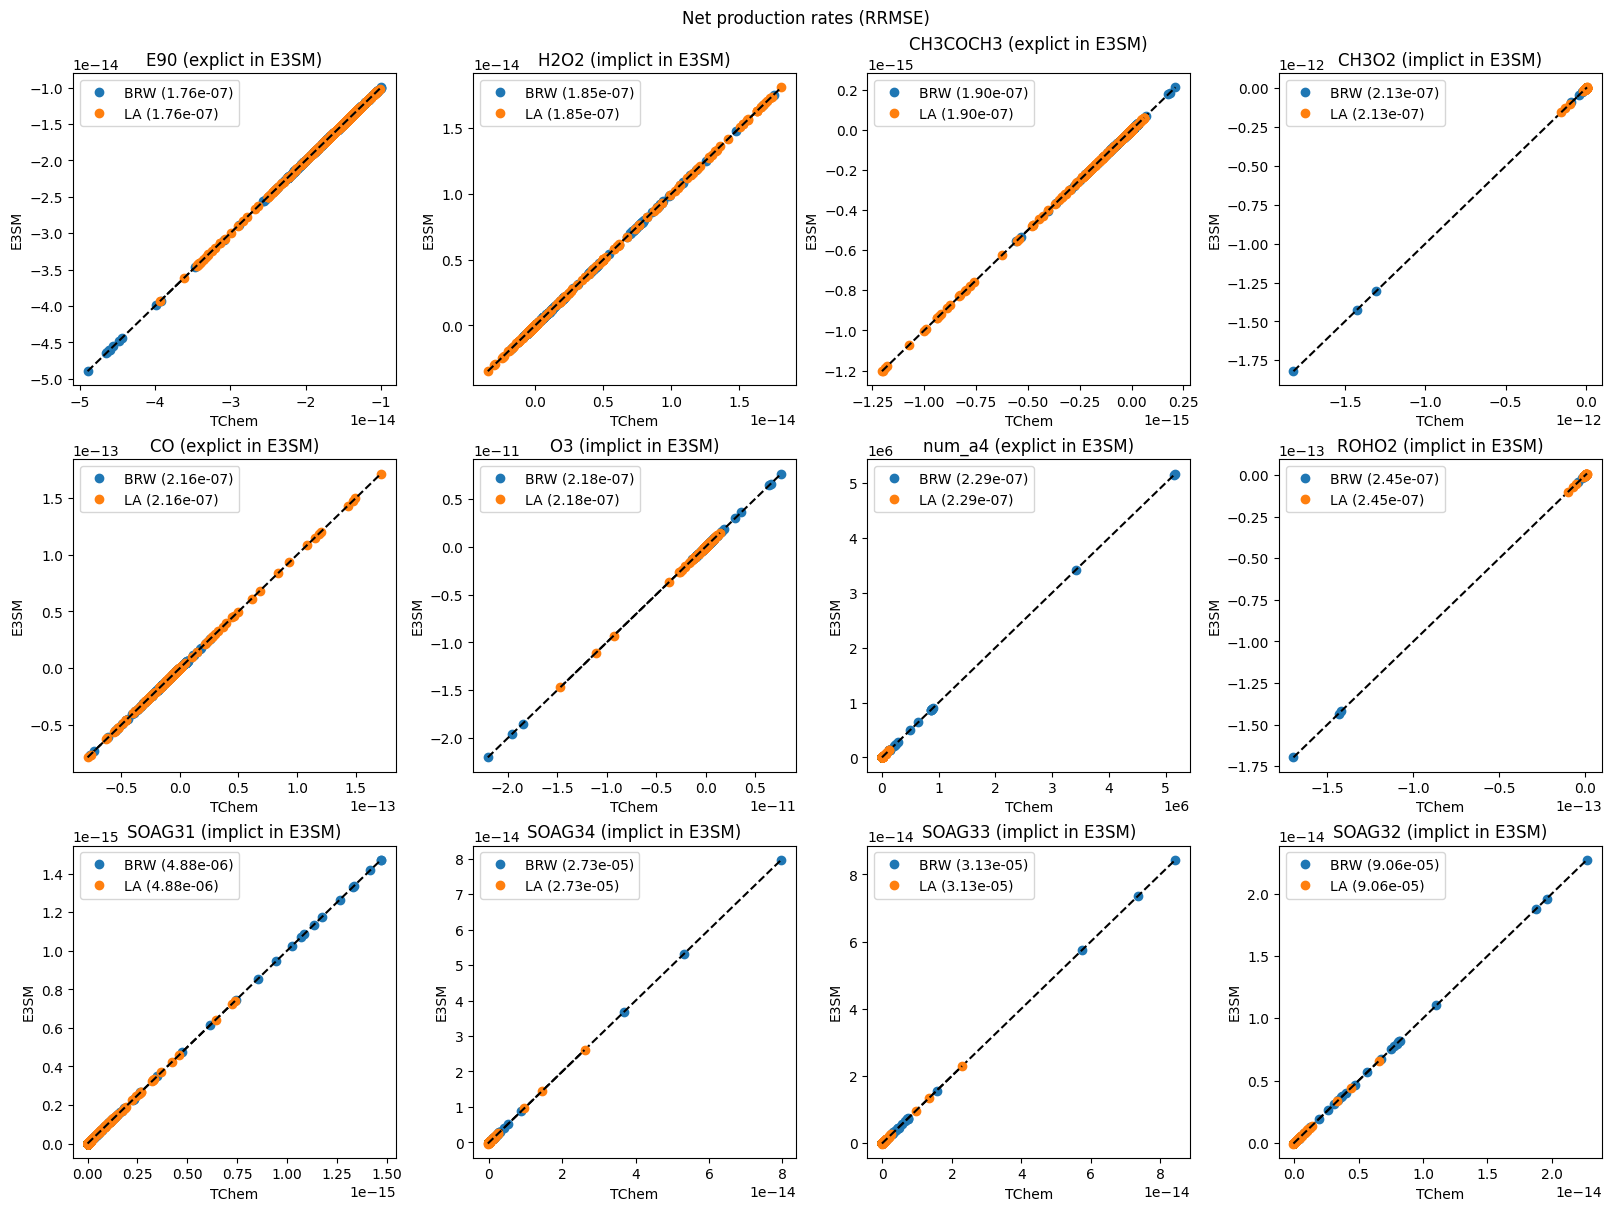

In [25]:
RRMSE_net_p_rate_c= np.array(RRMSE_net_p_rate["LA"]["RRMSE"])
where_are_NaNs = np.isnan(RRMSE_net_p_rate_c)
RRMSE_net_p_rate_c[where_are_NaNs] = 0
idx_error_RRMSE_net_p_rate = np.array(RRMSE_net_p_rate_c).argsort()
plot_these_variables = idx_error_RRMSE_net_p_rate[-no_plot_worst_rrmse:]

fig, axs = plt.subplots(nx, ny, layout="constrained", figsize=[ny*4,nx*4])
fig.suptitle('Net production rates (RRMSE)')
for i,idx_e3sm in enumerate(plot_these_variables):
    var = var_names_e3sm[idx_e3sm]
    j = int(i/ny)%nx
    k = i%ny
    if idx_e3sm+1 in explicit_species_idx:
      var_name = var + ' (explict in E3SM)'
    else:
      var_name = var + ' (implict in E3SM)'
    # print(j,k)
    # camp_idx=campHeader.index(campNames[var])
    idx_tchem =  names_tchem.index(var)
    for iloc in locas:
      reaction_tchem_net_production_rates = tchem_data[iloc]["net_prod_rates"]
      tchem_values= reaction_tchem_net_production_rates[:,idx_tchem]
      reaction_net_production_rate_uci_test = get_values_e3sm_net_production_rates(standalone_impl[iloc])
      e3sm_values =reaction_net_production_rate_uci_test[:,idx_e3sm]
      # idx_e3sm = var_names_e3sm.index(var)
      var_label = label_format.format(var_name=iloc,error=RRMSE_net_p_rate["LA"]["RRMSE"][idx_e3sm])
      plot_tchem_vs_e3sm(ax = axs[j][k], tchem_values=tchem_values,
                      e3sm_values=e3sm_values, var_label=var_name, legend_name=var_label)
plt.savefig("net_production_rate_worst.pdf")

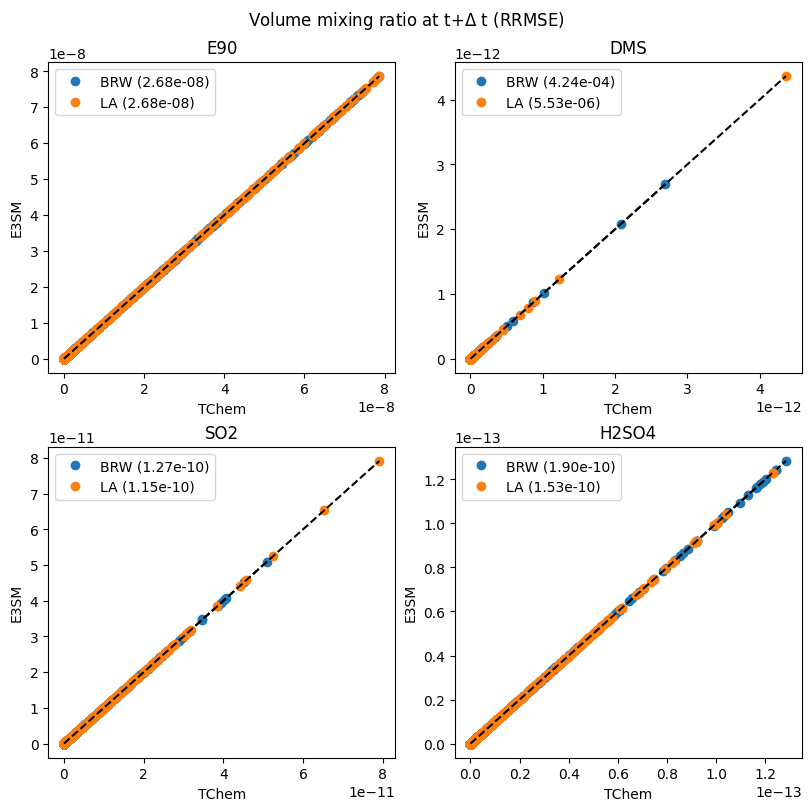

In [26]:
nx=2
ny=2
fig, axs = plt.subplots(nx, ny, layout="constrained", figsize=[ny*4,nx*4])
fig.suptitle('Volume mixing ratio at t+$\Delta$ t (RRMSE)')
explict_vars = Header_strato[6:-3]
for i,var in enumerate(explict_vars):
    j = int(i/ny)%nx
    k = i%ny
    idx_e3sm =  var_names_e3sm.index(var)
    idx_tchem =  Header_strato.index(var)

    for iloc in locas:
      solTchem_explicit = tchem_data_strato[iloc]["vmr"]
      tchem_values= solTchem_explicit[-1,:,idx_tchem]
      y_start_stra, y_end_stra = get_stratosphere_vmr(standalone[iloc])
      e3sm_values=y_end_stra[:,idx_e3sm]
      var_label = label_format.format(var_name=iloc,error=rel_l2(tchem_values, e3sm_values))
      plot_tchem_vs_e3sm(ax = axs[j][k], tchem_values=tchem_values,
                      e3sm_values=e3sm_values, var_label=var, legend_name=var_label)
plt.savefig("time_integration_stratoshere.pdf")

/var/folders/6k/g7sr4c6n26ddzjy8k30nrnb4002p1l/T/ipykernel_18668/1886437541.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return np.linalg.norm(predictions - targets) / np.linalg.norm(targets)


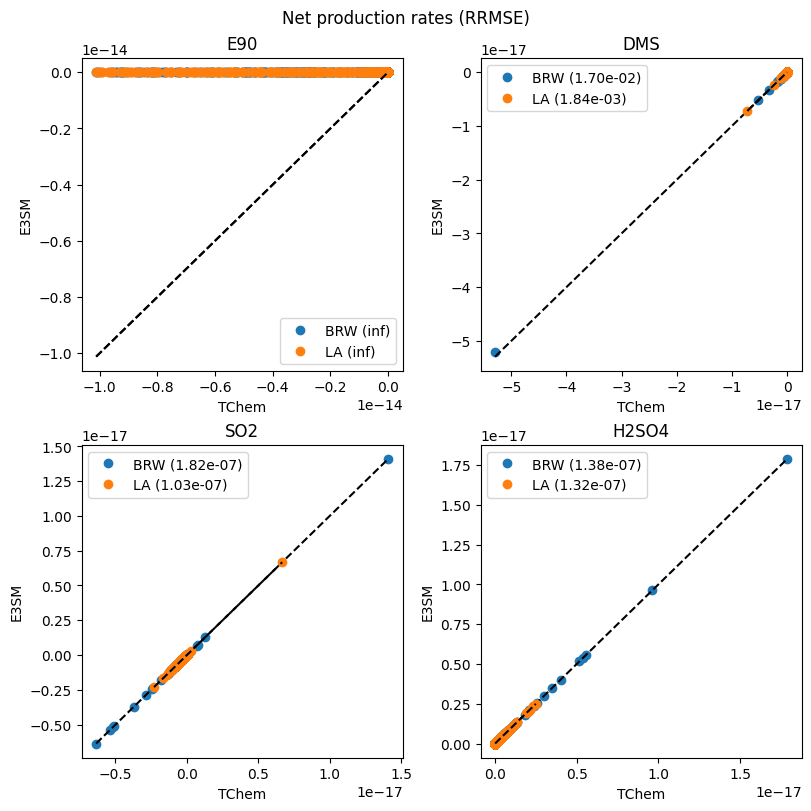

In [27]:
fig, axs = plt.subplots(nx, ny, layout="constrained", figsize=[ny*4,nx*4])
fig.suptitle('Net production rates (RRMSE)')
for i,var in enumerate(explict_vars):
    j = int(i/ny)%nx
    k = i%ny
    idx_e3sm =  var_names_e3sm.index(var)
    idx_tchem =  Header_strato.index(var)-6
    for iloc in locas:
      reaction_net_production_rate_uci_stra=get_values_e3sm_stratosphere_net_production_rates(standalone[iloc])
      net_production_rates=tchem_data_strato[iloc]["net_prod_rates"]
      tchem_values=net_production_rates[:,idx_tchem]
      e3sm_values=reaction_net_production_rate_uci_stra[:,idx_e3sm]
      var_label = label_format.format(var_name=iloc,error=rel_l2(tchem_values, e3sm_values))
      plot_tchem_vs_e3sm(ax = axs[j][k], tchem_values=tchem_values,
                      e3sm_values=e3sm_values, var_label=var, legend_name=var_label)
plt.savefig("net_production_rates_stratosphere.pdf")